In [5]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'
internet_path = '/content/drive/MyDrive/Colab Notebooks/tomato_images2/'


BATCH_SIZE = 256
IMG_SIZE = (75, 75)
SEED = 42

In [7]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

valid2_gen, test2_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    seed=SEED,
    validation_split=0.5,
    image_size=IMG_SIZE,
    subset="both",
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


test3_gen = tf.keras.utils.image_dataset_from_directory(
    internet_path,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid2_gen = valid2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test3_gen = test3_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid3_gen = test3_gen

Found 12803 files belonging to 9 classes.
Using 10883 files for training.
Using 1920 files for validation.
Found 37455 files belonging to 9 classes.
Using 18728 files for training.
Using 18727 files for validation.
Found 35 files belonging to 9 classes.


In [8]:
from tensorflow.keras.applications import ResNet101, DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
import time
import matplotlib.pyplot as plt

In [9]:
class TripleValidationCallback(Callback):
    def __init__(self, validation_gen2, validation_gen3):
        super().__init__()
        self.validation_gen2 = validation_gen2
        self.validation_gen3 = validation_gen3
        self.history = {'val2_loss': [], 'val2_acc': [], 'val3_loss': [], 'val3_acc': []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss2, val_acc2 = self.model.evaluate(self.validation_gen2, verbose=0)
        val_loss3, val_acc3 = self.model.evaluate(self.validation_gen3, verbose=0)
        logs['val2_loss'] = val_loss2
        logs['val2_acc'] = val_acc2
        logs['val3_loss'] = val_loss3
        logs['val3_acc'] = val_acc3
        self.history['val2_loss'].append(val_loss2)
        self.history['val2_acc'].append(val_acc2)
        self.history['val3_loss'].append(val_loss3)
        self.history['val3_acc'].append(val_acc3)


In [1]:
def create_and_train_model(base_model, model_filename, freeze_layers=True):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    triple_val_callback = TripleValidationCallback(validation_gen2=valid2_gen, validation_gen3=valid3_gen)

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=50, callbacks=[triple_val_callback])

    # Combine Keras history with custom callback history
    history = history.history
    history.update(triple_val_callback.history)

    # Save the model
    model.save(model_filename)

    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.plot(history['val2_loss'], label='Validation2 Loss')
    # plt.plot(history['val3_loss'], label='Validation3 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracies
    plt.figure()
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation1 Accuracy')
    plt.plot(history['val2_acc'], label='Validation2 Accuracy')
    # plt.plot(history['val3_acc'], label='Validation3 Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Measure inference time 3
    start_time = time.time()
    _, accuracy3 = model.evaluate(test3_gen)
    end_time = time.time()
    inference_time3 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    # Print results
    print(f"Model: {model_filename}")
    print(f"Params: {num_params}")
    print(f"Inference Time: {inference_time}")
    print(f"Accuracy: {accuracy}")
    print(f"Inference Time2: {inference_time2}")
    print(f"Accuracy2: {accuracy2}")
    print(f"Inference Time3: {inference_time3}")
    print(f"Accuracy3: {accuracy3}")



Epoch 1/50
36/36 [==============================] - 77s 348ms/step - loss: 0.4803 - accuracy: 0.8466 - val_loss: 9.2783 - val_accuracy: 0.3646 - val2_loss: 11.6682 - val2_acc: 0.3357 - val3_loss: 26.4831 - val3_acc: 0.1143
Epoch 2/50
36/36 [==============================] - 5s 150ms/step - loss: 0.0725 - accuracy: 0.9766 - val_loss: 4.6516 - val_accuracy: 0.5508 - val2_loss: 6.6668 - val2_acc: 0.4521 - val3_loss: 19.9580 - val3_acc: 0.2000
Epoch 3/50
36/36 [==============================] - 5s 151ms/step - loss: 0.0283 - accuracy: 0.9907 - val_loss: 2.0747 - val_accuracy: 0.7474 - val2_loss: 3.8374 - val2_acc: 0.6210 - val3_loss: 13.1737 - val3_acc: 0.2000
Epoch 4/50
36/36 [==============================] - 5s 152ms/step - loss: 0.0194 - accuracy: 0.9932 - val_loss: 1.0049 - val_accuracy: 0.8014 - val2_loss: 2.1209 - val2_acc: 0.6805 - val3_loss: 12.5294 - val3_acc: 0.2000
Epoch 5/50
36/36 [==============================] - 5s 151ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.

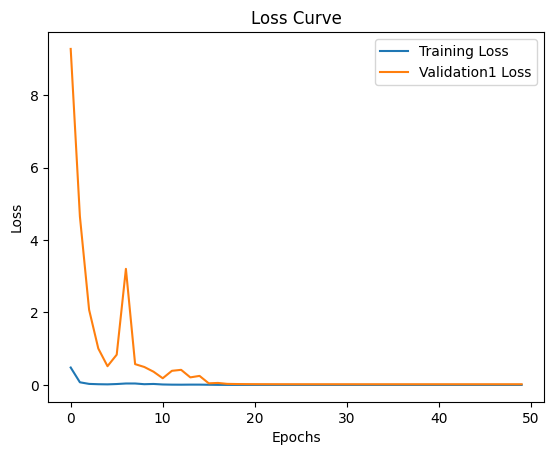

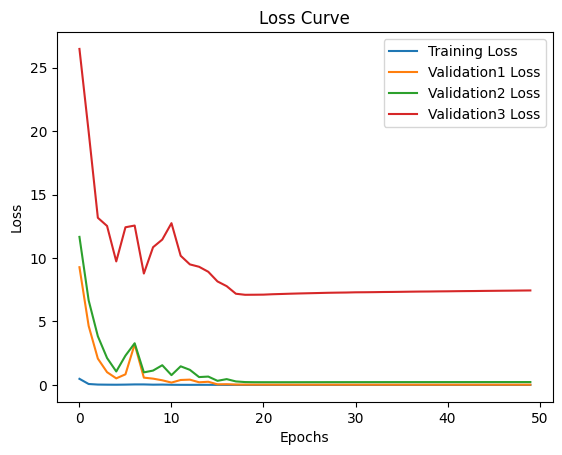

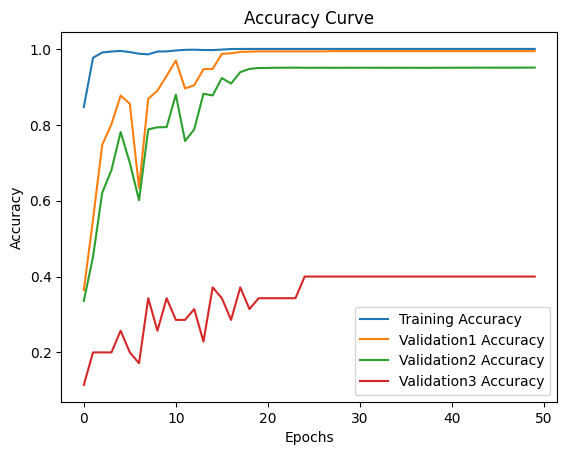

1/1 [==============================] - 0s 23ms/step - loss: 7.4459 - accuracy: 0.4000
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e.model
Params: 7046729
Inference Time: 0.47620344161987305
Accuracy: 0.9901041388511658
Inference Time2: 2.521378993988037
Accuracy2: 0.9518876671791077
Inference Time3: 0.033632516860961914
Accuracy3: 0.4000000059604645


In [10]:
# Create and train DenseNet121 75 256
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e.model', freeze_layers=False)

29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/50
36/36 [==============================] - 80s 359ms/step - loss: 0.5092 - accuracy: 0.8363 - val_loss: 8.7106 - val_accuracy: 0.2480 - val2_loss: 9.3489 - val2_acc: 0.2372 - val3_loss: 16.1624 - val3_acc: 0.2286
Epoch 2/50
36/36 [==============================] - 6s 159ms/step - loss: 0.0709 - accuracy: 0.9766 - val_loss: 2.6562 - val_accuracy: 0.5684 - val2_loss: 3.7542 - val2_acc: 0.4775 - val3_loss: 8.5700 - val3_acc: 0.2286
Epoch 3/50
36/36 [==============================] - 6s 158ms/step - loss: 0.0217 - accuracy: 0.9947 - val_loss: 0.6090 - val_accuracy: 0.8464 - val2_loss: 1.4803 - val2_acc: 0.6904 - val3_loss: 6.9291 - val3_acc: 0.2571
Epoch 4/50
36/36 [==============================] - 6s 159ms/step - loss: 0.0110 - accuracy: 0.9959 - val_loss: 0.2764 - val_accuracy: 0.9199 - val2_loss: 0.7228 - val2_acc: 0.8224 - val3_loss: 5.5010 - val3_acc: 0.3714
Epoch 5/50
36/36 [==============================] - 6

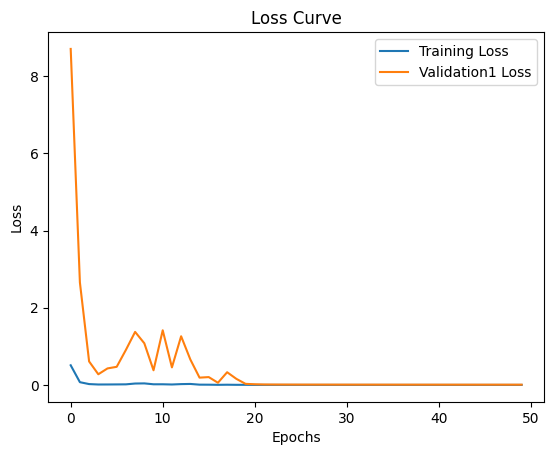

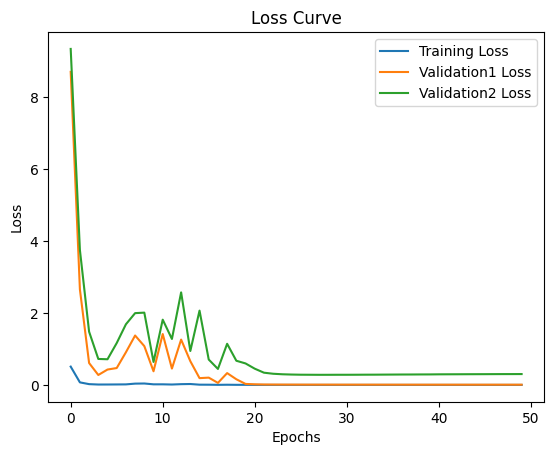

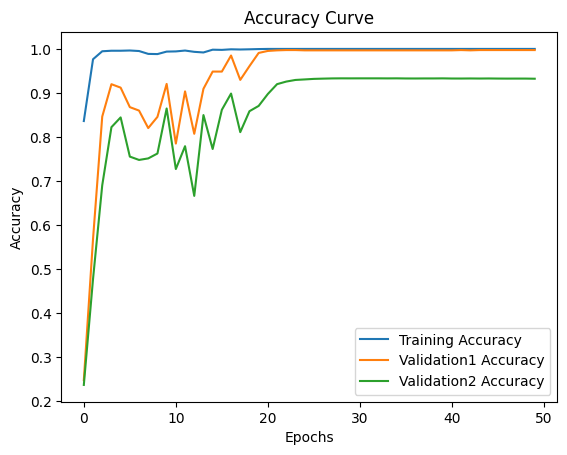

1/1 [==============================] - 0s 25ms/step - loss: 6.4667 - accuracy: 0.4000
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e2.model
Params: 7046729
Inference Time: 0.46575307846069336
Accuracy: 0.989062488079071
Inference Time2: 2.4963114261627197
Accuracy2: 0.9362418055534363
Inference Time3: 0.0361025333404541
Accuracy3: 0.4000000059604645


In [10]:
# Create and train DenseNet121 75 256
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e2.model', freeze_layers=False)

51877672/51877672 [==============================] - 3s 0us/step
Epoch 1/50
36/36 [==============================] - 86s 267ms/step - loss: 0.4580 - accuracy: 0.8505 - val_loss: 59.8536 - val_accuracy: 0.1667 - val2_loss: 62.2206 - val2_acc: 0.1427 - val3_loss: 50.0735 - val3_acc: 0.0286
Epoch 2/50
36/36 [==============================] - 7s 194ms/step - loss: 0.0754 - accuracy: 0.9766 - val_loss: 26.8306 - val_accuracy: 0.1947 - val2_loss: 28.7299 - val2_acc: 0.1646 - val3_loss: 30.0637 - val3_acc: 0.0571
Epoch 3/50
36/36 [==============================] - 7s 193ms/step - loss: 0.0392 - accuracy: 0.9883 - val_loss: 3.3680 - val_accuracy: 0.6263 - val2_loss: 4.7060 - val2_acc: 0.5179 - val3_loss: 11.1718 - val3_acc: 0.1714
Epoch 4/50
36/36 [==============================] - 7s 195ms/step - loss: 0.0280 - accuracy: 0.9913 - val_loss: 1.0406 - val_accuracy: 0.8405 - val2_loss: 1.5821 - val2_acc: 0.7643 - val3_loss: 7.5000 - val3_acc: 0.3143
Epoch 5/50
36/36 [=============================

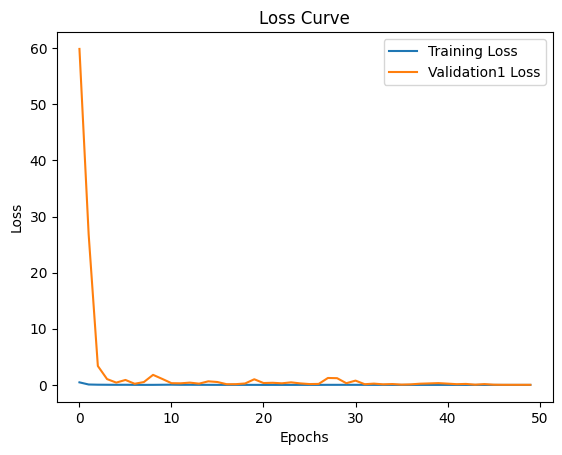

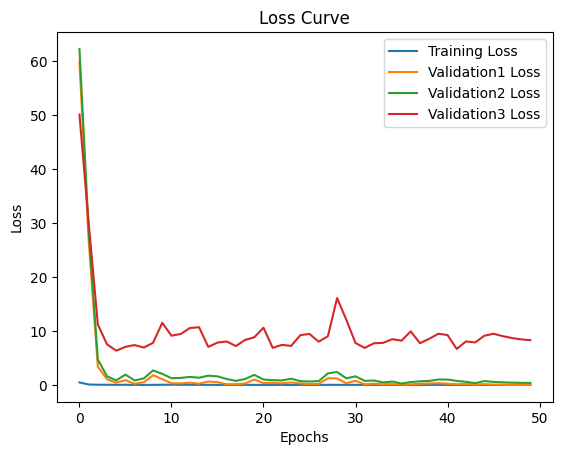

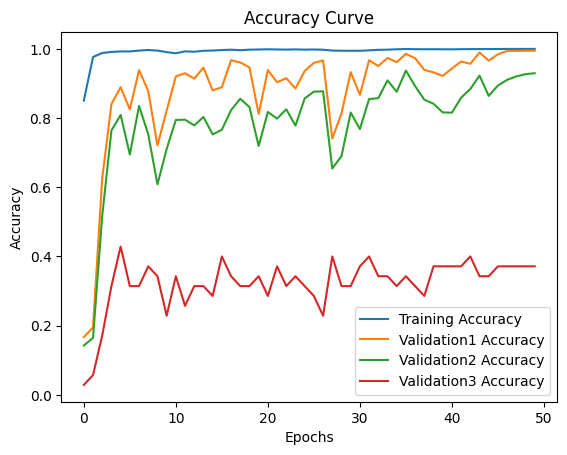

1/1 [==============================] - 0s 27ms/step - loss: 8.2766 - accuracy: 0.3714
Model: /content/drive/MyDrive/Colab Notebooks/densenet169_tomatoAll_75s_256b_50e.model
Params: 12657865
Inference Time: 0.3078434467315674
Accuracy: 0.989062488079071
Inference Time2: 2.395465135574341
Accuracy2: 0.9341058135032654
Inference Time3: 0.04045367240905762
Accuracy3: 0.37142857909202576


In [11]:
# Create and train DenseNet169 75 256
densenet_base = DenseNet169(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet169_tomatoAll_75s_256b_50e.model', freeze_layers=False)

74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/50
36/36 [==============================] - 105s 408ms/step - loss: 0.4576 - accuracy: 0.8462 - val_loss: 14.8164 - val_accuracy: 0.2370 - val2_loss: 14.6920 - val2_acc: 0.2378 - val3_loss: 18.7340 - val3_acc: 0.2286
Epoch 2/50
36/36 [==============================] - 8s 229ms/step - loss: 0.0790 - accuracy: 0.9743 - val_loss: 19.4258 - val_accuracy: 0.1855 - val2_loss: 21.8404 - val2_acc: 0.1585 - val3_loss: 26.1862 - val3_acc: 0.0571
Epoch 3/50
36/36 [==============================] - 8s 229ms/step - loss: 0.0395 - accuracy: 0.9874 - val_loss: 1.3446 - val_accuracy: 0.7480 - val2_loss: 2.3956 - val2_acc: 0.6384 - val3_loss: 8.8289 - val3_acc: 0.2571
Epoch 4/50
36/36 [==============================] - 8s 228ms/step - loss: 0.0233 - accuracy: 0.9915 - val_loss: 1.1670 - val_accuracy: 0.8138 - val2_loss: 2.6980 - val2_acc: 0.6569 - val3_loss: 8.5883 - val3_acc: 0.2571
Epoch 5/50
36/36 [=============================

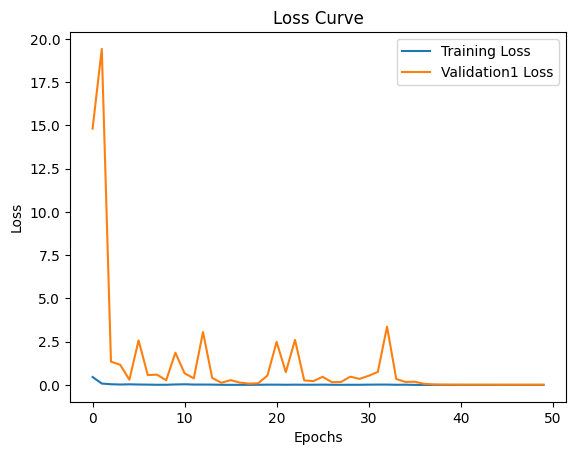

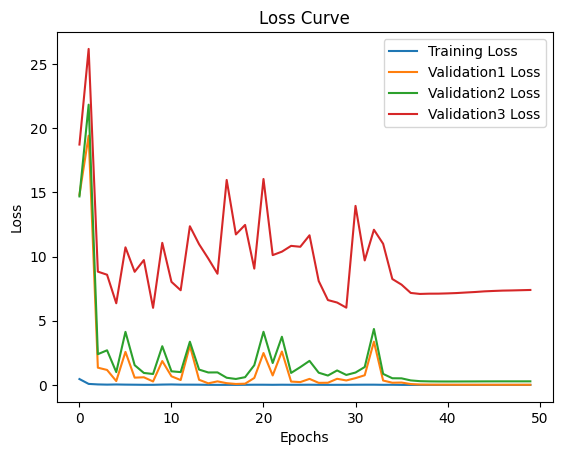

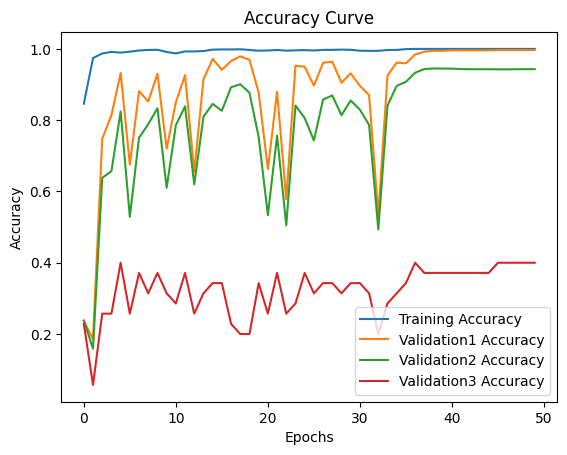

1/1 [==============================] - 0s 30ms/step - loss: 7.4002 - accuracy: 0.4000
Model: /content/drive/MyDrive/Colab Notebooks/densenet201_tomatoAll_75s_256b_50e.model
Params: 18339273
Inference Time: 0.3626110553741455
Accuracy: 0.9901041388511658
Inference Time2: 2.85129976272583
Accuracy2: 0.9456933736801147
Inference Time3: 0.04470658302307129
Accuracy3: 0.4000000059604645


In [12]:
# Create and train DenseNet201 75 256
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet201_tomatoAll_75s_256b_50e.model', freeze_layers=False)

Epoch 1/50
9/9 [==============================] - 65s 1s/step - loss: 0.8821 - accuracy: 0.7262 - val_loss: 6.0319 - val_accuracy: 0.2690 - val2_loss: 5.9780 - val2_acc: 0.2637 - val3_loss: 10.9356 - val3_acc: 0.1714
Epoch 2/50
9/9 [==============================] - 4s 432ms/step - loss: 0.0991 - accuracy: 0.9674 - val_loss: 7.6507 - val_accuracy: 0.2632 - val2_loss: 7.5463 - val2_acc: 0.2590 - val3_loss: 11.8831 - val3_acc: 0.2000
Epoch 3/50
9/9 [==============================] - 4s 431ms/step - loss: 0.0183 - accuracy: 0.9958 - val_loss: 5.5224 - val_accuracy: 0.2944 - val2_loss: 5.8450 - val2_acc: 0.2766 - val3_loss: 8.2595 - val3_acc: 0.1714
Epoch 4/50
9/9 [==============================] - 4s 432ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 4.4007 - val_accuracy: 0.3579 - val2_loss: 4.7772 - val2_acc: 0.3271 - val3_loss: 7.5043 - val3_acc: 0.2000
Epoch 5/50
9/9 [==============================] - 4s 431ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 3.4544 - val_accur

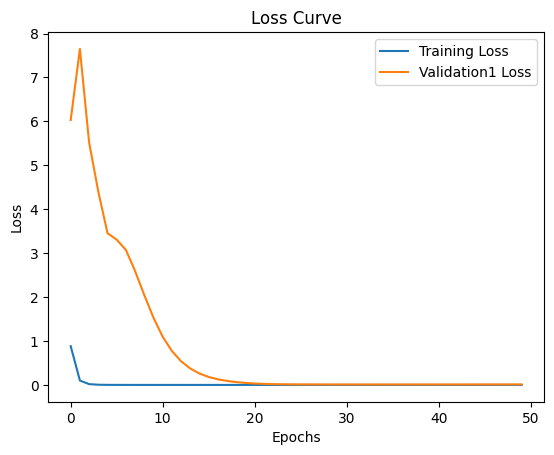

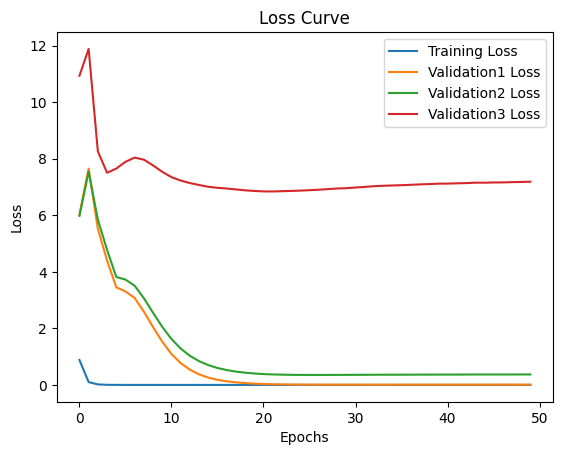

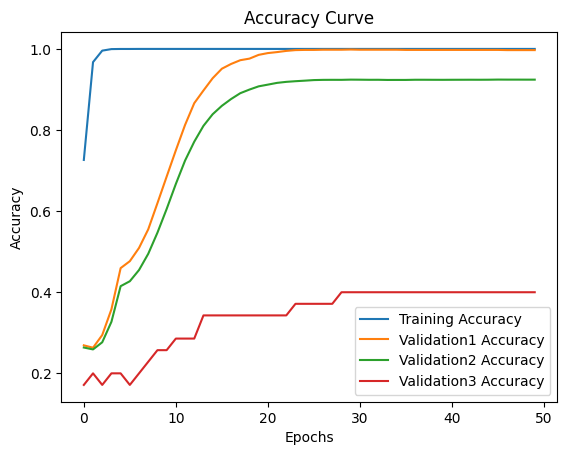

1/1 [==============================] - 0s 24ms/step - loss: 7.1865 - accuracy: 0.4000
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_1024b_50e.model
Params: 7046729
Inference Time: 0.5875425338745117
Accuracy: 0.981249988079071
Inference Time2: 2.2927985191345215
Accuracy2: 0.9295669198036194
Inference Time3: 0.03580331802368164
Accuracy3: 0.4000000059604645


In [15]:
# Create and train DenseNet121 75 1024
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_1024b_50e.model', freeze_layers=False)

Epoch 1/50
73/73 [==============================] - 103s 627ms/step - loss: 0.2174 - accuracy: 0.9275 - val_loss: 4.9343 - val_accuracy: 0.5000 - val2_loss: 4.8976 - val2_acc: 0.5036 - val3_loss: 12.0729 - val3_acc: 0.1429
Epoch 2/50
73/73 [==============================] - 41s 560ms/step - loss: 0.0480 - accuracy: 0.9844 - val_loss: 0.4915 - val_accuracy: 0.8835 - val2_loss: 0.7699 - val2_acc: 0.8139 - val3_loss: 9.2499 - val3_acc: 0.2286
Epoch 3/50
73/73 [==============================] - 41s 560ms/step - loss: 0.0243 - accuracy: 0.9936 - val_loss: 0.4638 - val_accuracy: 0.8686 - val2_loss: 1.2669 - val2_acc: 0.7424 - val3_loss: 6.7544 - val3_acc: 0.3143
Epoch 4/50
73/73 [==============================] - 41s 560ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.1306 - val_accuracy: 0.9538 - val2_loss: 0.7072 - val2_acc: 0.8731 - val3_loss: 9.0802 - val3_acc: 0.3429
Epoch 5/50
73/73 [==============================] - 41s 560ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 1

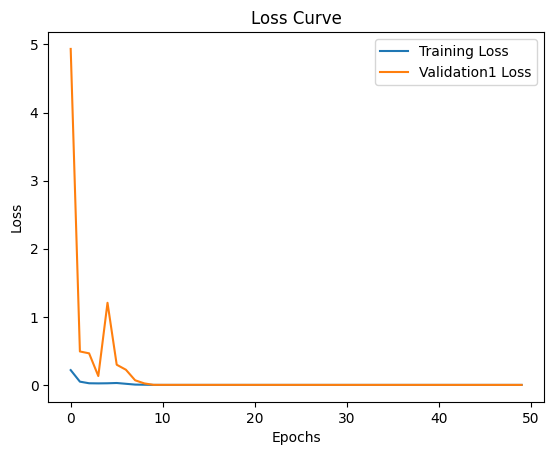

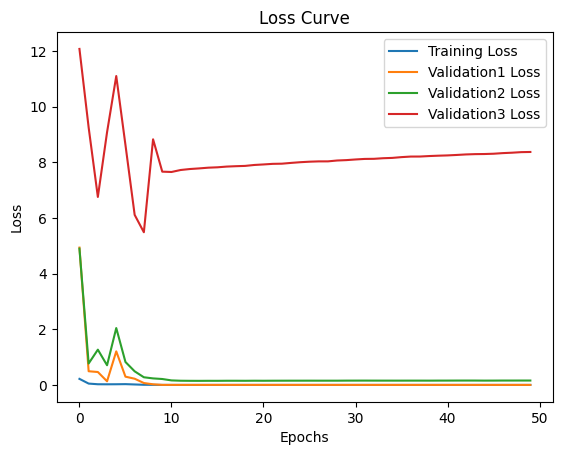

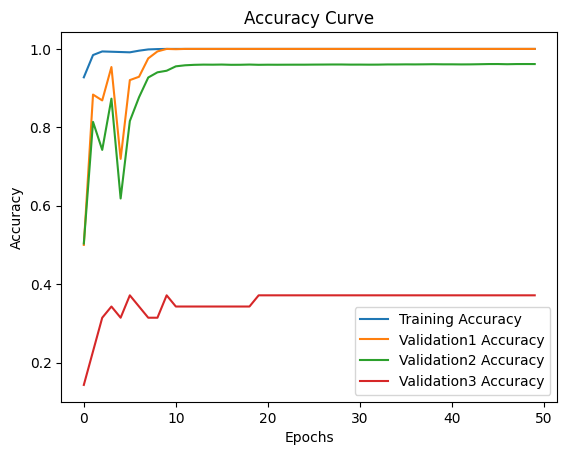

1/1 [==============================] - 0s 48ms/step - loss: 8.3700 - accuracy: 0.3714
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_50e.model
Params: 7046729
Inference Time: 1.8216423988342285
Accuracy: 0.9984375238418579
Inference Time2: 17.385109663009644
Accuracy2: 0.9618732333183289
Inference Time3: 0.05907869338989258
Accuracy3: 0.37142857909202576


In [18]:
# Create and train DenseNet121 256 128
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_256s_128b_50e.model', freeze_layers=False)